In [3]:
import pandas as pd
import os

# Define the file paths to our saved data
processed_dir = '../data/processed'
full_data_path = os.path.join(processed_dir, 'full_ohlcv_data.csv')
returns_path = os.path.join(processed_dir, 'daily_returns.csv')

# --- CORRECTED LINE ---
# We tell pandas to use the first two rows (0 and 1) as the multi-level header
# and the first column (0) as the index.
full_data = pd.read_csv(full_data_path, header=[0, 1], index_col=0, parse_dates=True)

# The daily_returns file has a simple header, so it loads correctly as before
daily_returns = pd.read_csv(returns_path, index_col='Date', parse_dates=True)

print("✅ Data successfully loaded!")
print("\n--- Full OHLCV Data ---")
print(full_data.head())

✅ Data successfully loaded!

--- Full OHLCV Data ---
Price           Close                              High              \
Ticker            BND         SPY       TSLA        BND         SPY   
Date                                                                  
2015-07-01  60.816715  174.917084  17.943333  60.914441  175.363859   
2015-07-02  60.967110  174.756958  18.667999  61.027251  175.566219   
2015-07-06  61.177586  174.259552  18.648001  61.222695  175.043511   
2015-07-07  61.237690  175.355469  17.858667  61.470731  175.481910   
2015-07-08  61.410629  172.413498  16.997334  61.463252  174.293327   

Price                        Low                              Open  \
Ticker           TSLA        BND         SPY       TSLA        BND   
Date                                                                 
2015-07-01  18.174667  60.764093  174.124686  17.856667  60.794164   
2015-07-02  18.830000  60.937039  174.335471  18.220667  60.937039   
2015-07-06  18.779333  61.05

In [4]:
import pandas_ta as ta

# 1. Create a new DataFrame for TSLA's features from the loaded data
tsla_features = pd.DataFrame({
    'Open': full_data['Open']['TSLA'],
    'High': full_data['High']['TSLA'],
    'Low': full_data['Low']['TSLA'],
    'Close': full_data['Close']['TSLA'],
    'Volume': full_data['Volume']['TSLA']
})

# 2. Calculate technical indicators and append them as new columns
tsla_features.ta.rsi(append=True)
tsla_features.ta.macd(append=True)

# 3. Clean the data by dropping rows with initial NaN values
# (Indicators need a "warm-up" period, creating NaNs at the start)
tsla_features.dropna(inplace=True)

print("✅ Multi-feature dataset for TSLA is now ready!")
print("\n--- Dataset Info ---")
tsla_features.info()

print("\n--- First 5 Rows of the Feature Set ---")
print(tsla_features.head())

✅ Multi-feature dataset for TSLA is now ready!

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2502 entries, 2015-08-18 to 2025-07-30
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           2502 non-null   float64
 1   High           2502 non-null   float64
 2   Low            2502 non-null   float64
 3   Close          2502 non-null   float64
 4   Volume         2502 non-null   int64  
 5   RSI_14         2502 non-null   float64
 6   MACD_12_26_9   2502 non-null   float64
 7   MACDh_12_26_9  2502 non-null   float64
 8   MACDs_12_26_9  2502 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 195.5 KB

--- First 5 Rows of the Feature Set ---
                 Open       High        Low      Close     Volume     RSI_14  \
Date                                                                           
2015-08-18  17.025333  17.396667  16.903999  17.381332   62925000  53.

/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [ ]:
# Our features 'X' are all the columns in the DataFrame
X = tsla_features

# Our target variable 'y' is the 'Close' price we want to predict
y = tsla_features['Close']

# Define the split date
split_date = '2024-01-01'

# Split both X and y chronologically
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]

y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

# Verify the shapes of our new datasets
print("--- Multi-Feature Data Splitting Complete ---")
print(f"Shape of X_train (features): {X_train.shape}")
print(f"Shape of X_test (features): {X_test.shape}")
print(f"Shape of y_train (target): {y_train.shape}")
print(f"Shape of y_test (target): {y_test.shape}")
X.head()

--- Multi-Feature Data Splitting Complete ---
Shape of X_train (features): (2107, 9)
Shape of X_test (features): (395, 9)
Shape of y_train (target): (2107,)
Shape of y_test (target): (395,)


Date
2015-08-18    17.381332
2015-08-19    17.016666
2015-08-20    16.145332
2015-08-21    15.384667
2015-08-24    14.591333
Name: Close, dtype: float64

In [6]:
import statsmodels.api as sm

# 1. Select our exogenous features
exog_features = ['Volume', 'RSI_14']

# 2. Create and train the SARIMAX model
print("Training the SARIMAX model...")

# We use the 'SARIMAX' class from statsmodels to create our model
sarimax_model = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train[exog_features],
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0)
).fit(disp=False)

print("✅ SARIMAX model training complete!")
print("\n--- Model Summary ---")
print(sarimax_model.summary())

Training the SARIMAX model...
✅ SARIMAX model training complete!

--- Model Summary ---
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2107
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6191.029
Date:                Fri, 22 Aug 2025   AIC                          12392.057
Time:                        18:52:46   BIC                          12420.320
Sample:                             0   HQIC                         12402.408
                               - 2107                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume      4.428e-09   1.37e-09      3.235      0.001    1.75e-09    7.11e-09
RSI_14         0.8056      0.011     76.402

/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 1. Preprocess the Multi-Feature Data ---

# 1a. Scale all feature columns
# We use one scaler for the input features (X)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_X_train = scaler_features.fit_transform(X_train)

# And a separate scaler for our single target variable (y)
# This makes it easy to inverse-transform the predictions later
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_y_train = scaler_target.fit_transform(y_train.values.reshape(-1, 1))

# 1b. Create training sequences
sequence_length = 60
X_train_multi = []
y_train_multi = []
num_features = X_train.shape[1] # Get the number of features

for i in range(sequence_length, len(scaled_X_train)):
    # Append the sequence of all features
    X_train_multi.append(scaled_X_train[i-sequence_length:i, :]) 
    # Append the corresponding single target value
    y_train_multi.append(scaled_y_train[i, 0])

X_train_multi, y_train_multi = np.array(X_train_multi), np.array(y_train_multi)
print(f"Shape of multi-variate training data: {X_train_multi.shape}")


# --- 2. Build the Model Architecture ---

model_lstm_multi = Sequential()

# The input_shape now includes the number of features
model_lstm_multi.add(LSTM(
    units=50, 
    return_sequences=True, 
    input_shape=(sequence_length, num_features) # Key change here!
))
model_lstm_multi.add(Dropout(0.2))

model_lstm_multi.add(LSTM(units=50, return_sequences=False))
model_lstm_multi.add(Dropout(0.2))

model_lstm_multi.add(Dense(units=1))


# --- 3. Compile and Train the Model ---

model_lstm_multi.compile(optimizer='adam', loss='mean_squared_error')

print("\nTraining the Multi-variate LSTM model... this may take a few minutes. 🧠")
model_lstm_multi.fit(X_train_multi, y_train_multi, epochs=25, batch_size=32)
print("✅ Multi-variate LSTM model training complete!")

2025-08-22 18:52:46.923241: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-22 18:52:46.932632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-22 18:52:47.275450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly o

Shape of multi-variate training data: (2047, 60, 9)

Training the Multi-variate LSTM model... this may take a few minutes. 🧠
Epoch 1/25


2025-08-22 18:52:49.647305: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0134
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018
Epoch 9/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017
Epoch 10/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017
Epoch 11/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019
Epoch 12/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017
Epoch 13/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015
Epoch 14/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 15/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 16/25
64/

Generating SARIMAX forecast... 🔮
Generating Multi-variate LSTM forecast... 🧠


/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



--- Model Performance Metrics ---
SARIMAX -> MAE: $59.77 | RMSE: $74.63 | MAPE: 22.59%
LSTM ->    MAE: $15.74 | RMSE: $21.17 | MAPE: 5.57%


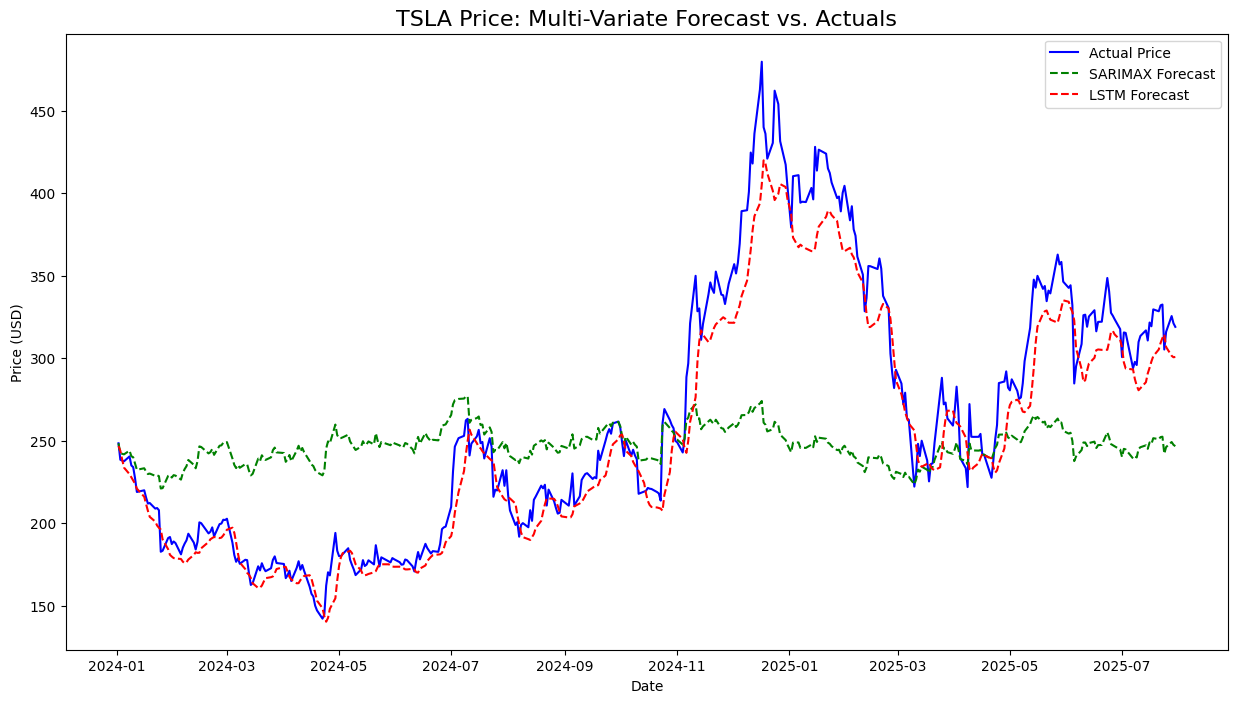

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. Generate SARIMAX Forecast (with Index Correction) ---
print("Generating SARIMAX forecast... 🔮")
exog_features = ['Volume', 'RSI_14']
forecast_values = sarimax_model.forecast(steps=len(y_test), exog=X_test[exog_features])


# Manually assign the correct test set index to the predictions.
sarimax_predictions = pd.Series(forecast_values.values, index=y_test.index)


# --- 2. Generate Multi-variate LSTM Forecast ---
print("Generating Multi-variate LSTM forecast... 🧠")
# (The rest of the LSTM code remains the same as before)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_X_train = scaler_features.fit_transform(X_train)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_y_train = scaler_target.fit_transform(y_train.values.reshape(-1,1))
sequence_length = 60

scaled_X_test = scaler_features.transform(X_test)
# Prepend last part of training data to form the first test sequence
full_scaled_X = np.concatenate((scaled_X_train, scaled_X_test), axis=0)
X_test_multi = []
for i in range(len(scaled_X_train), len(full_scaled_X)):
    X_test_multi.append(full_scaled_X[i-sequence_length:i, :])
X_test_multi = np.array(X_test_multi)

lstm_predictions_scaled = model_lstm_multi.predict(X_test_multi, verbose=0)
lstm_predictions = scaler_target.inverse_transform(lstm_predictions_scaled).flatten()
lstm_predictions = pd.Series(lstm_predictions, index=y_test.index)


# --- 3. Compare Performance & Visualize ---
# (This part remains the same)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n--- Model Performance Metrics ---")
# SARIMAX Metrics
mae_sarimax = mean_absolute_error(y_test, sarimax_predictions)
rmse_sarimax = np.sqrt(mean_squared_error(y_test, sarimax_predictions))
mape_sarimax = mean_absolute_percentage_error(y_test, sarimax_predictions)
print(f"SARIMAX -> MAE: ${mae_sarimax:.2f} | RMSE: ${rmse_sarimax:.2f} | MAPE: {mape_sarimax:.2f}%")

# LSTM Metrics
mae_lstm = mean_absolute_error(y_test, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_predictions))
mape_lstm = mean_absolute_percentage_error(y_test, lstm_predictions)
print(f"LSTM ->    MAE: ${mae_lstm:.2f} | RMSE: ${rmse_lstm:.2f} | MAPE: {mape_lstm:.2f}%")

plt.figure(figsize=(15, 8))
plt.plot(y_test, color='blue', label='Actual Price')
plt.plot(sarimax_predictions, color='green', linestyle='--', label='SARIMAX Forecast')
plt.plot(lstm_predictions, color='red', linestyle='--', label='LSTM Forecast')
plt.title('TSLA Price: Multi-Variate Forecast vs. Actuals', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [9]:
# --- Build the Upgraded LSTM Architecture ---

upgraded_lstm_model = Sequential()

# Layer 1: Increased units to 128
upgraded_lstm_model.add(LSTM(
    units=128, 
    return_sequences=True, 
    input_shape=(sequence_length, num_features)
))
upgraded_lstm_model.add(Dropout(0.2))

# Layer 2: Increased units to 256
upgraded_lstm_model.add(LSTM(units=256, return_sequences=False))
upgraded_lstm_model.add(Dropout(0.2))

# Layer 3: A dense layer to consolidate features
upgraded_lstm_model.add(Dense(units=64))

# Adding another dense layer for more complexity
upgraded_lstm_model.add(Dense(units=28))

# Final Output Layer
upgraded_lstm_model.add(Dense(units=1))


# --- Compile and Train the Upgraded Model ---

upgraded_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

print("\nTraining the Upgraded LSTM model for more epochs...")
# Increased epochs to 50
upgraded_lstm_model.fit(X_train_multi, y_train_multi, epochs=50, batch_size=32)
print("✅ Upgraded LSTM model training complete!")


Training the Upgraded LSTM model for more epochs...
Epoch 1/50


/home/shivers/dev/github.com/AbenezerWork/finance-time-series-forecasting/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0114
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0015
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011    
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 9.9465e-04
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 9.7526e-04
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0011
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0012
Epoch 14/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.5366e-04
Epoch 15/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 7.8259

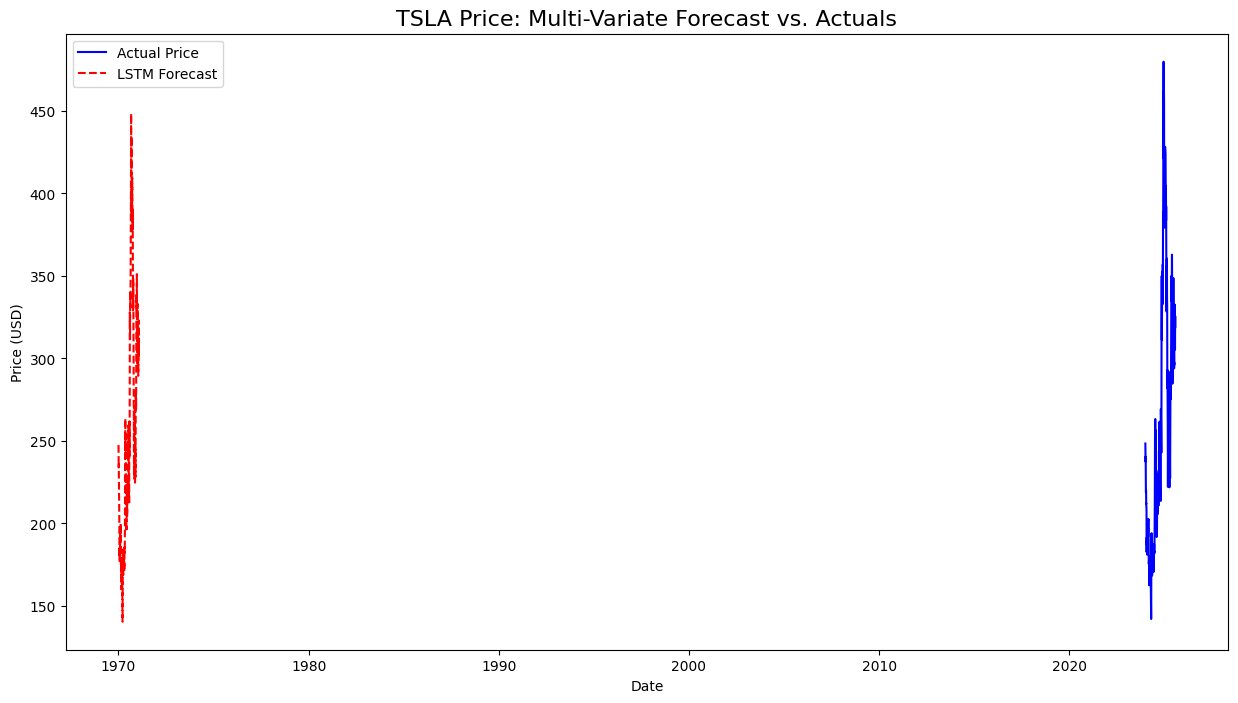

In [15]:
lstm_predictions_scaled = upgraded_lstm_model.predict(X_test_multi, verbose=0)
lstm_predictions = scaler_target.inverse_transform(lstm_predictions_scaled)



plt.figure(figsize=(15, 8))
plt.plot(y_test, color='blue', label='Actual Price')
plt.plot(lstm_predictions, color='red', linestyle='--', label='LSTM Forecast')
plt.title('TSLA Price: Multi-Variate Forecast vs. Actuals', fontsize=16)
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()

In [11]:
# --- 1. Generate Predictions from the Upgraded Model ---
print("Generating predictions from the upgraded LSTM model... 🧠")

# Scale the test features using the already fitted scaler
scaled_X_test = scaler_features.transform(X_test)

# Create the test sequences by prepending the end of the training data
full_scaled_X = np.concatenate((scaled_X_train, scaled_X_test), axis=0)
X_test_upgraded = []
for i in range(len(scaled_X_train), len(full_scaled_X)):
    X_test_upgraded.append(full_scaled_X[i-sequence_length:i, :])
X_test_upgraded = np.array(X_test_upgraded)

# Make predictions
upgraded_predictions_scaled = upgraded_lstm_model.predict(X_test_upgraded, verbose=0)

# Inverse transform the predictions to get dollar values
upgraded_predictions = scaler_target.inverse_transform(upgraded_predictions_scaled).flatten()
upgraded_predictions = pd.Series(upgraded_predictions, index=y_test.index)


# --- 2. Calculate and Compare Metrics ---

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate metrics for the upgraded model
mae_upgraded = mean_absolute_error(y_test, upgraded_predictions)
rmse_upgraded = np.sqrt(mean_squared_error(y_test, upgraded_predictions))
mape_upgraded = mean_absolute_percentage_error(y_test, upgraded_predictions)

# Print the side-by-side comparison
print("\n--- Model Performance Comparison ---")
print(f"LSTM ->    MAE: ${mae_lstm:.2f} | RMSE: ${rmse_lstm:.2f} | MAPE: {mape_lstm:.2f}%")
print(f"Upgraded LSTM -> MAE: ${mae_upgraded:.2f} | RMSE: ${rmse_upgraded:.2f} | MAPE: {mape_upgraded:.2f}%")

Generating predictions from the upgraded LSTM model... 🧠

--- Model Performance Comparison ---
LSTM ->    MAE: $15.74 | RMSE: $21.17 | MAPE: 5.57%
Upgraded LSTM -> MAE: $9.63 | RMSE: $13.73 | MAPE: 3.54%


In [13]:
import os
from joblib import dump

# --- Save the Final Model and Scalers ---

# Create a 'models' directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# 1. Save the trained Keras model
model_path = os.path.join(models_dir, 'final_lstm_model.keras')
upgraded_lstm_model.save(model_path)

# 2. Save the scalers using joblib
feature_scaler_path = os.path.join(models_dir, 'feature_scaler.joblib')
target_scaler_path = os.path.join(models_dir, 'target_scaler.joblib')
dump(scaler_features_final, feature_scaler_path)
dump(scaler_target_final, target_scaler_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Feature scaler saved to: {feature_scaler_path}")
print(f"✅ Target scaler saved to: {target_scaler_path}")

NameError: name 'scaler_features_final' is not defined